In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import sys
import datetime
import time
import json
from tqdm import tqdm
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import nibabel as nib

from models.losses import *
from utils.plot import *

tick_size = 20

sns.set(rc={
    'figure.figsize':(10,10), 
    'font.size': 25, 
    "axes.labelsize":25, 
    "xtick.labelsize": tick_size, 
    "ytick.labelsize": tick_size,
    'font.family':'serif',
    'grid.linestyle': '',
    'axes.facecolor': 'white',
    'axes.edgecolor': '0.2',
    'axes.spines.bottom': True,
    'axes.spines.left': True,
    'axes.spines.right': True,
    'axes.spines.top': True,
    'image.cmap': 'Greys_r',
    'image.interpolation': 'none',
})

palette = sns.color_palette("Set2", n_colors=6, desat=1)

/home/local/VANDERBILT/remedis/anaconda3/envs/tf2_py37/lib/python3.7/site-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


In [2]:
DATA_DIR = Path("/nfs/share5/remedis/data/CQS_TBI/manually_segmented/test")
ct_fnames = sorted([x for x in DATA_DIR.iterdir() if "CT" in x.name])
MASK_DIR = Path("/nfs/share5/remedis/data/CQS_TBI/manually_segmented/test/preprocessed")
mask_fnames = sorted([x for x in MASK_DIR.iterdir() if "mask" in x.name])

In [3]:
SEG_DIR = Path("/nfs/share5/remedis/data/CQS_TBI/manually_segmented/test/segmentations/")
seg_dirs = sorted([x for x in SEG_DIR.iterdir() if x.is_dir() and x.name.startswith("mode")])

In [4]:
seg_fnames = [sorted(s.iterdir()) for s in seg_dirs]

In [5]:
def window(ct, w, l):
    max_val = l + (w / 2)
    min_val = l - (w / 2)
    ct[np.where(ct >= max_val)] = max_val
    ct[np.where(ct <= min_val)] = min_val
    return ct

In [6]:
def find_slice(mask):
    '''
    Returns index of slice with largest mask volume.
    '''
    biggest_hemorrhage_idx = 0
    biggest_hemorrhage = 0
    
    for i, sl in enumerate(mask.transpose(2,0,1)):
        if sl.sum() > biggest_hemorrhage:
            biggest_hemorrhage = sl.sum()
            biggest_hemorrhage_idx = i
            
    return biggest_hemorrhage_idx

In [31]:
plt.rcParams['figure.figsize'] = (20, 20)

CQS_TBI11428_CT.nii.gz Local A: 0.67
CQS_TBI11428_CT.nii.gz Local B: 0.73
CQS_TBI11428_CT.nii.gz Cyc A: 0.73
CQS_TBI11428_CT.nii.gz Cyc B: 0.71
CQS_TBI11428_CT.nii.gz FWA: 0.71
CQS_TBI11428_CT.nii.gz FGA: 0.77


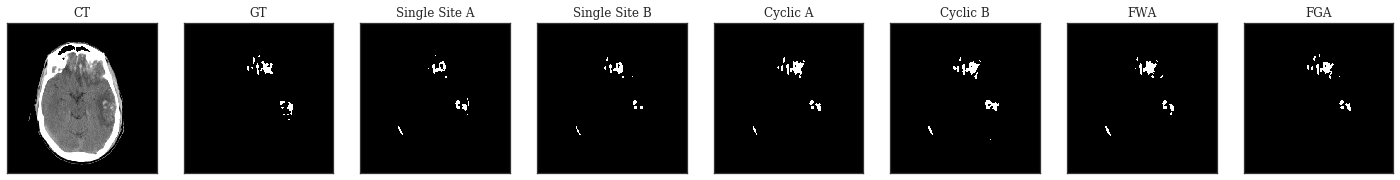

In [33]:
for fname_tuple in zip(ct_fnames, mask_fnames, *seg_fnames):
    ct_fname, mask_fname, *seg_fname = fname_tuple
    
    if ct_fname.name != "CQS_TBI11428_CT.nii.gz":
        continue
    
    cyc_a, cyc_b, fga, local_a, local_b, fwa = seg_fname
    
    print("{}".format("="*20))
    
    ct = nib.load(ct_fname).get_fdata()
    mask = nib.load(mask_fname).get_fdata()[:, ::-1, :]
    cyc_a_pred = nib.load(cyc_a).get_fdata()[:, ::-1, :].round()
    cyc_b_pred = nib.load(cyc_b).get_fdata()[:, ::-1, :].round()
    fga_pred = nib.load(fga).get_fdata()[:, ::-1, :].round()
    local_a_pred = nib.load(local_a).get_fdata()[:, ::-1, :].round()
    local_b_pred = nib.load(local_b).get_fdata()[:, ::-1, :].round()
    fwa_pred = nib.load(fwa).get_fdata()[:, ::-1, :].round()
    
    sl_idx = find_slice(mask)
    
    ct = window(ct, 130, 50)
    
    
    print("{} Local A: {:.2f}".format(ct_fname.name, dice_coef(mask, local_a_pred)))
    print("{} Local B: {:.2f}".format(ct_fname.name, dice_coef(mask, local_b_pred)))
    print("{} Cyc A: {:.2f}".format(ct_fname.name, dice_coef(mask, cyc_a_pred)))
    print("{} Cyc B: {:.2f}".format(ct_fname.name, dice_coef(mask, cyc_b_pred)))
    print("{} FWA: {:.2f}".format(ct_fname.name, dice_coef(mask, fwa_pred)))
    print("{} FGA: {:.2f}".format(ct_fname.name, dice_coef(mask, fga_pred)))
    
    
    multiplot(
        [
            ct[:,:,sl_idx], 
            mask[:,:,sl_idx], 
            local_a_pred[:,:,sl_idx],
            local_b_pred[:,:,sl_idx],
            cyc_a_pred[:,:,sl_idx],
            cyc_b_pred[:,:,sl_idx],
            fwa_pred[:,:,sl_idx],
            fga_pred[:,:,sl_idx],
        ],
        [
            'CT', 
            'GT', 
            'Single Site A',
            'Single Site B',
            'Cyclic A',
            'Cyclic B',
            'FWA',
            'FGA',
        ]
    )
    
    print("{}".format("="*20))